In [134]:
import numpy as np
import pandas as pd
import imageio
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.color import gray2rgb
import glob #Task 3
import warnings
warnings.filterwarnings("ignore")

In [135]:
def conv2(img, conv_filter):
    # flip the filter
    f_siz_1, f_size_2 = conv_filter.shape
    conv_filter = conv_filter[range(f_siz_1 - 1, -1, -1), :][:, range(f_siz_1 - 1, -1, -1)]
    pad = (conv_filter.shape[0] - 1) // 2
    result = np.zeros((img.shape))
    img = np.pad(img, ((pad, pad), (pad, pad)), 'constant', constant_values=(0, 0))
    filter_size = conv_filter.shape[0]
    for r in np.arange(img.shape[0] - filter_size + 1):
        for c in np.arange(img.shape[1] - filter_size + 1):
            curr_region = img[r:r + filter_size, c:c + filter_size]
            curr_result = curr_region * conv_filter
            conv_sum = np.sum(curr_result)  # Summing the result of multiplication.
            result[r, c] = conv_sum  # Saving the summation in the convolution layer feature map.

    return result

In [136]:
def fspecial(shape=(3, 3), sigma=0.5):
    m, n = [(ss - 1.) / 2. for ss in shape]
    y, x = np.ogrid[-m:m + 1, -n:n + 1]
    h = np.exp(-(x * x + y * y) / (2. * sigma * sigma))
    h[h < np.finfo(h.dtype).eps * h.max()] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

In [137]:
# Parameters, add more if needed
sigma = 2
thresh = 0.01
# Derivative masks
dx = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
dy = dx.transpose()

In [138]:
bw = plt.imread('Task1/Harris_4.jpg')
bw = rgb2gray(bw)

bw = np.array(bw * 255, dtype=int)

# compute the image's x and y derivatives
Ix = conv2(bw, dx)
Iy = conv2(bw, dy)

In [139]:
g = fspecial((max(1, np.floor(3 * sigma) * 2 + 1), max(1, np.floor(3 * sigma) * 2 + 1)), sigma)
Iy2 = conv2(np.power(Iy, 2), g)
Ix2 = conv2(np.power(Ix, 2), g)
Ixy = conv2(Ix * Iy, g)

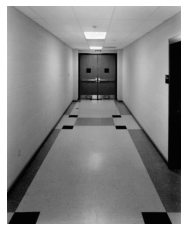

In [140]:
img = imread('Task1/Harris_4.jpg')
img = gray2rgb(img)
#converted rgb2gray for faster computation
imggray = rgb2gray(img)

plt.imshow(imggray, cmap="gray")
plt.axis("off")
plt.show()

In [143]:
def func_harris_r():
    # taking the contanst value which ranges from [0.4,0.6]  to be 0.5 after hit & trial
    k = 0.05

    # computing determinant
    detA = Ix2 * Iy2 - Ixy ** 2
    # computing trace
    traceA = Ix2 + Iy2

    # Calculating the harris response after substituting the values for the determinant, trace and k
    harris_response = detA - k * traceA ** 2
    return harris_response
harris_response_ = func_harris_r()

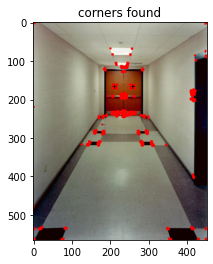

In [144]:
def non_max_supp(harris_response):
    img_copy_for_corners = np.copy(img)
    #Nonmaximum Supression
    # Using sigma to supress points
    harris_response = (harris_response>sigma*abs(np.mean(harris_response)))*harris_response
    harris_response = cv2.dilate(harris_response,None)
    # Using threshold to supress points
    for rowindex, response in enumerate(harris_response):
        for colindex, r in enumerate(response):
            if r > thresh*harris_response.max():
                img_copy_for_corners[rowindex, colindex] = [255,0,0]
    return img_copy_for_corners
img_copy_for_corners = non_max_supp(harris_response_)
plt.title("corners found")
plt.imshow(img_copy_for_corners,cmap='gray')
plt.show()

# Using cv2

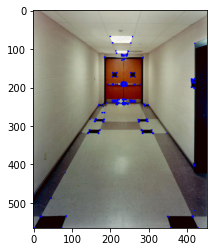

In [145]:
img = imageio.imread('Task1/Harris_4.jpg')
gray = rgb2gray(img)
img = gray2rgb(img)
gray = np.float32(gray)
dst = cv2.cornerHarris(gray,2,3,0.01)
#result is dilated for marking the corners, not important
dst = cv2.dilate(dst,None)
# Threshold for an optimal value, it may vary depending on the image.
img[dst>0.01*dst.max()]=[0,0,255]
plt.imshow(img,cmap='gray')

# Task 2 K-Means Clustering and Color Image Segmentation.

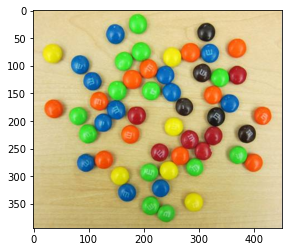

In [91]:
image = imageio.imread('Task2/mandm.png')
image_8bit = cv2.convertScaleAbs(image)
plt.imshow(image_8bit)
plt.show()

In [41]:
from sklearn.metrics import pairwise_distances


def get_initial_centroids(data, k, seed=None):
    """As initial centroids, select k data points at random."""
    if seed is not None:  # a good way to get consistent results
        np.random.seed(seed)
    n = data.shape[0]  # the total number of data points

    # Choose K indices from the [0, N] set.
    rand_indices = np.random.randint(0, n, k)

    # Since several entries would be nonzero due to averaging, keep centroids in a dense format.
    # As long as at least one document in a cluster contains a term, the cluster is considered complete.
    # It will have a nonzero weight in the centroid's TF-IDF vector.
    centroids = data[rand_indices, :]

    return centroids


def my_centroid_pairwise_dist(X, centroids):
    # using the imported pairwise_distances function from sklearn.metrics to calculate pairwise dist.
    return pairwise_distances(X, centroids, metric="euclidean")


def my_assign_clusters(data, centroids):

    # Calculate the distances between each data point and the set of centroids using the following formula:
    distances_from_centroids = my_centroid_pairwise_dist(data, centroids)

    # Calculate each data point's cluster assignment:
    cluster_assignment = np.argmin(distances_from_centroids, axis=1)

    return cluster_assignment


def my_revise_centroids(data, k, cluster_assignment):
    new_centroids = []
    for i in range(k):
        # All data points that belong to cluster I should be selected.
        member_data_points = data[cluster_assignment == i]
        # Calculate the data points' mean.
        centroid = member_data_points.mean(axis=0)
        new_centroids.append(centroid)
    new_centroids = np.array(new_centroids)

    return new_centroids



def my_kmeans(data, k, initial_centroids, maxiter=450):
    """This function applies k-means to a collection of data and initial centroids.
    maxiter: The maximum number of iterations that can be performed.(450 is the default)"""
    centroids = initial_centroids[:]
    prev_cluster_assignment = None

    for itr in range(maxiter):

        # 1. Assign clusters based on the centroids that are closest to each other.
        cluster_assignment = my_assign_clusters(data, centroids)

        # 2. For each of the k clusters, compute a new centroid by averaging all data points.
        #    That cluster was given a certain number of points.
        centroids = my_revise_centroids(data, k, cluster_assignment)

        # Check for convergence and move on to the next step if none of the assignments have changed.
        if (
            prev_cluster_assignment is not None
            and (prev_cluster_assignment == cluster_assignment).all()
        ):
            break

        if prev_cluster_assignment is not None:
            num_changed = np.sum(prev_cluster_assignment != cluster_assignment)


        prev_cluster_assignment = cluster_assignment[:]

    return centroids, cluster_assignment

In [42]:
# In Lab without xy
im_bgr = cv2.cvtColor(image_8bit, cv2.COLOR_RGB2BGR)
lab_img = cv2.cvtColor(im_bgr, cv2.COLOR_BGR2LAB)
pixel_values = im_bgr.reshape((-1, 3))
pixel_values = np.float32(pixel_values)
print(pixel_values.shape)

(177694, 3)


In [43]:
int_centroids = get_initial_centroids(pixel_values, 3, seed=42)
centers, clus_assgn = my_kmeans(pixel_values, 3, int_centroids, maxiter=100)
centers = np.uint8(centers)
clus_assgn = clus_assgn.astype(int)
labels = clus_assgn.flatten()
segmented_image = centers[labels.flatten()]
segmented_image = segmented_image.reshape(image_8bit.shape)
cv2.imshow('k=3 in Lab', segmented_image) 
cv2.waitKey(0)         
cv2.destroyAllWindows()

In [44]:
int_centroids = get_initial_centroids(pixel_values, 6, seed=42)
centers, clus_assgn = my_kmeans(pixel_values, 6, int_centroids, maxiter=100)
centers = np.uint8(centers)
clus_assgn = clus_assgn.astype(int)
labels = clus_assgn.flatten()
segmented_image = centers[labels.flatten()]
segmented_image = segmented_image.reshape(image_8bit.shape)
print(image_8bit.shape)
cv2.imshow('k=6 in Lab', segmented_image) 
cv2.waitKey(0)         
cv2.destroyAllWindows()

(394, 451, 3)


In [45]:
int_centroids = get_initial_centroids(pixel_values, 8, seed=42)
centers, clus_assgn = my_kmeans(pixel_values, 8, int_centroids, maxiter=100)
centers = np.uint8(centers)
clus_assgn = clus_assgn.astype(int)
labels = clus_assgn.flatten()
segmented_image = centers[labels.flatten()]
segmented_image = segmented_image.reshape(image_8bit.shape)
cv2.imshow('k=8 in Lab', segmented_image) 
cv2.waitKey(0)         
cv2.destroyAllWindows()

In [56]:
# convert to grayscale
gray = cv2.cvtColor(image_8bit,cv2.COLOR_BGR2GRAY)
# get coordinates (x,y)
xy_coords = np.flip(np.column_stack(np.where(gray >= 0)), axis=1)
print(len(xy_coords))
xy_np_arr = np.asarray(xy_coords)

177694


In [57]:
# In Lab with x y
im_bgr = cv2.cvtColor(image_8bit, cv2.COLOR_RGB2BGR)
lab_img = cv2.cvtColor(im_bgr, cv2.COLOR_BGR2LAB)
pixel_values = im_bgr.reshape((-1, 3))
pixel_values = np.float32(pixel_values)
pixel_values_xy = np.empty((177694,5), dtype=float)

for i in range(pixel_values.shape[0]):
    pixel_values_xy[i][0] = pixel_values[i][0]
    pixel_values_xy[i][1] = pixel_values[i][1]
    pixel_values_xy[i][2] = pixel_values[i][2]
    pixel_values_xy[i][3] = xy_np_arr[i][0]
    pixel_values_xy[i][4] = xy_np_arr[i][1]

        
print(pixel_values_xy.shape)


(177694, 5)


In [59]:
int_centroids = get_initial_centroids(pixel_values_xy, 16, seed=42)
centers, clus_assgn = my_kmeans(pixel_values_xy, 16, int_centroids, maxiter=100)
centers = np.uint8(centers)
clus_assgn = clus_assgn.astype(int)
labels = clus_assgn.flatten()
segmented_image = centers[labels.flatten()]
segmented_image = np.delete(segmented_image, 3, axis=1)
segmented_image = np.delete(segmented_image, 3, axis=1)
# print(segmented_image.shape)
segmented_image = segmented_image.reshape(image_8bit.shape)
cv2.imshow('k=16 in Lab', segmented_image) 
cv2.waitKey(0)         
cv2.destroyAllWindows()

In [92]:
import sys

In [93]:
# This function calculates euclidean distance.
def distance(p1, p2):
    return np.sum((p1 - p2)**2)
   
# The procedure for initialization
def my_initialization(data, k):
    '''
    Centroid initializtion for K-means++
    inputs:
        data - a numpy list having shape of data points (177694, 5)
        k - the quantity of clusters 
    '''
    ## initialize the centroids list and add
    ## a randomly selected data point to the list
    centroids = []
    centroids.append(data[np.random.randint(data.shape[0]), :])

   
    ## Calculating remaining k - 1 centroids
    for c_id in range(k - 1):
          
        ## initialize a list to store distances of data
        ## points from nearest centroid
        dist = []
        for i in range(data.shape[0]):
            point = data[i, :]
            d = sys.maxsize
              
            
            ## Calculate the distance between 'point' and each previously 
            ## selected centroid and save the shortest distance.
            for j in range(len(centroids)):
                temp_dist = distance(point, centroids[j])
                d = min(d, temp_dist)
            dist.append(d)
              
        ## As our next centroid, choose the data point with the greatest distance.
        dist = np.array(dist)
        next_centroid = data[np.argmax(dist), :]
        centroids.append(next_centroid)
        dist = []
    return centroids


In [94]:
# In Lab with x y
im_bgr = cv2.cvtColor(image_8bit, cv2.COLOR_RGB2BGR)
lab_img = cv2.cvtColor(im_bgr, cv2.COLOR_BGR2LAB)
pixel_values = im_bgr.reshape((-1, 3))
pixel_values = np.float32(pixel_values)
pixel_values_xy = np.empty((177694,5), dtype=float)

for i in range(pixel_values.shape[0]):
    pixel_values_xy[i][0] = pixel_values[i][0]
    pixel_values_xy[i][1] = pixel_values[i][1]
    pixel_values_xy[i][2] = pixel_values[i][2]
    pixel_values_xy[i][3] = xy_np_arr[i][0]
    pixel_values_xy[i][4] = xy_np_arr[i][1]

        
print(pixel_values_xy.shape)

(177694, 5)


In [95]:
int_centroids = my_initialization(pixel_values_xy, 8)
print(int_centroids)
centers, clus_assgn = my_kmeans(pixel_values_xy, 8, int_centroids, maxiter=100)
centers = np.uint8(centers)
clus_assgn = clus_assgn.astype(int)
labels = clus_assgn.flatten()
segmented_image = centers[labels.flatten()]
segmented_image = np.delete(segmented_image, 3, axis=1)
segmented_image = np.delete(segmented_image, 3, axis=1)
# print(segmented_image.shape)
segmented_image = segmented_image.reshape(image_8bit.shape)
cv2.imshow('k=8 in Labxy kmean++', segmented_image) 
cv2.waitKey(0)         
cv2.destroyAllWindows()

[array([141.,  81.,   5., 222., 331.]), array([163., 214., 240., 446.,   2.]), array([ 13., 234., 248.,  23.,  74.]), array([187., 214., 228., 449., 375.]), array([  0.,  27.,  33., 320.,  26.]), array([142., 196., 213.,   0., 372.]), array([245., 171.,  69., 146.,  30.]), array([  2.,  92., 255., 271., 253.])]


# Task 3 Face Dtection using Eigen Face and PCA

In [57]:
import scipy.stats
import glob
import numpy as np
from numpy import linalg as la
from pylab import *
import IPython
from IPython.display import display, HTML

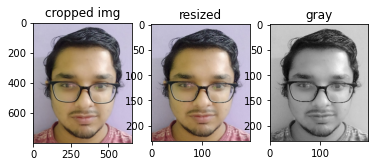

In [15]:
img = Image.open('Task3/subject16.1.png')
width, height = img.size   # Get dimensions
img_new = img
width_u = 656
height_u = 800
lt = (width - width_u)/2 # how much to be cropped from left
rt = (width + width_u)/2 # how much to be cropped from right
tp = (height - height_u)/2 # how much to be cropped from top
bt = (height + height_u)/2 # how much to be cropped from bottom

# Cropping the center of the image and displaying
img_cropped = img.crop((lt, tp, rt, bt))
plt.subplot(1, 3, 1).set_title('cropped img')
plt.imshow(np.uint8(img_cropped))

# converting pil image to opencv image
open_cv_image = np.asarray(img_cropped.convert('RGB')) 

# resizing image and displaying
img_resized = cv2.resize(open_cv_image,(195,231), interpolation=cv2.INTER_LINEAR)

plt.subplot(1, 3, 2).set_title('resized')
plt.imshow(np.uint8(img_resized))

# converting image to gray
gray_image = cv2.cvtColor(img_resized, cv2.COLOR_RGB2GRAY)
plt.subplot(1, 3, 3).set_title('gray')
plt.imshow(np.uint8(gray_image),cmap='gray')

Image.fromarray(gray_image).save('Task3/Yale-FaceA/trainingset/subject16.1.png') # saving the image 


plt.show()

# continued in the next cell

In [15]:
# I will apply the same to all the images
max = 11 
open_loc = 'Task3/subject16.'
sav_loc = 'Task3/Yale-FaceA/trainingset/subject16.'
for i in range(2,max+1):
    cur_open = open_loc+str(i)+'.png'
    img = Image.open(cur_open)
    width, height = img.size   # Get dimensions
    img_new = img
    width_u = 680
    height_u = 820
    lt = (width - width_u)/2 # how much to be cropped from left
    rt = (width + width_u)/2 # how much to be cropped from right
    tp = (height - height_u)/2 # how much to be cropped from top
    bt = (height + height_u)/2 # how much to be cropped from bottom
    img_cropped = img.crop((lt, tp, rt, bt))
    open_cv_image = np.asarray(img_cropped.convert('RGB'))
    img_resized = cv2.resize(open_cv_image,(195,231), interpolation=cv2.INTER_LINEAR)
    gray_image = cv2.cvtColor(img_resized, cv2.COLOR_RGB2GRAY)
    cur_sav = sav_loc+str(i)+'.png'
    Image.fromarray(gray_image).save(cur_sav) # saving the image
    
    
    

135


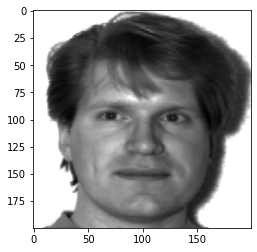

In [133]:
image = []
# collecting all the train images using glob
for filename in glob.glob('Task3/Yale-FaceA/trainingset/*.png'):
    im=Image.open(filename)   
    im= np.asarray(im,dtype=float)
#     resizing as square to reduce confusions in computations, also bilinear interpolation is used
    im = cv2.resize(im,(200,200),interpolation = cv2.INTER_LINEAR)
    im = im/255.0
    image.append(im)
print(len(image))
plt.imshow(image[0],cmap='gray')

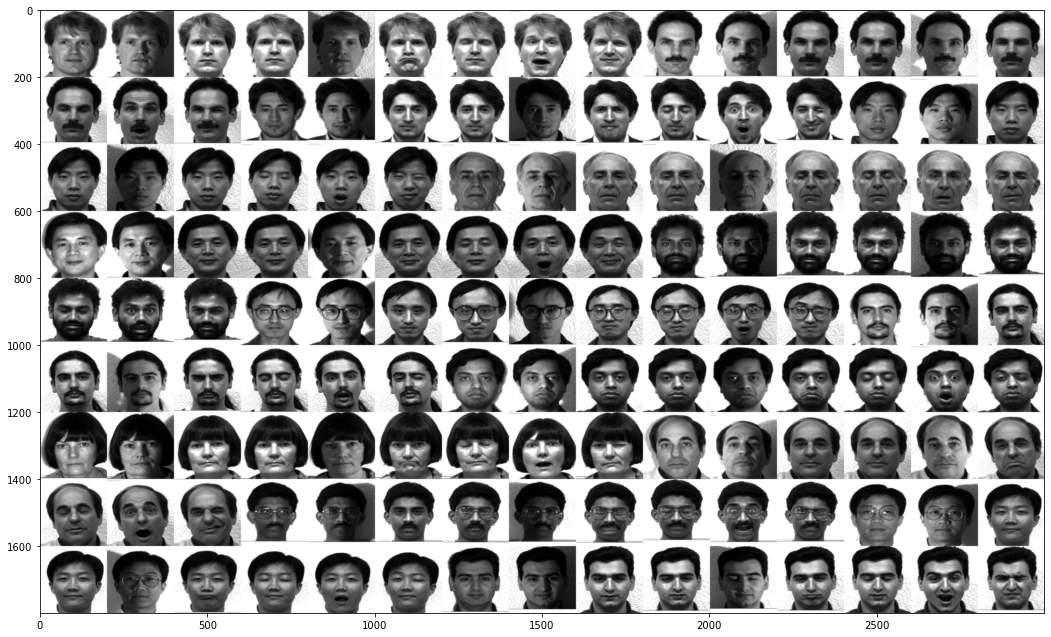

In [134]:
# The function tasks is to view multiple images using single imshow
def gallery(array, ncols=15):
    nindex, height, width = array.shape
    nrows = nindex//ncols
    assert nindex == nrows*ncols
    # want result.shape = (height*nrows, width*ncols, intensity)
    result = (array.reshape(nrows, ncols, height, width)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols))
    return result
result = gallery(np.asarray(image))
plt.figure(figsize=(18, 18))
plt.imshow(result, interpolation='bilinear',cmap='gray')
plt.show()

In [135]:
flattened_images = []
for i in range(len(image)):
    p=image[i].flatten()
#     flattening image to make computation possible
    flattened_images.append(p)
A_transpose = np.matrix(flattened_images)
A = np.transpose(A_transpose)

mean= np.mean(A,1)
b= mean.reshape(200,200)
resized_mean = cv2.resize(b,(100,100),interpolation = cv2.INTER_LINEAR)

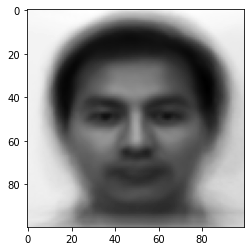

In [136]:
plt.imshow(resized_mean,cmap='gray')

Mean Face


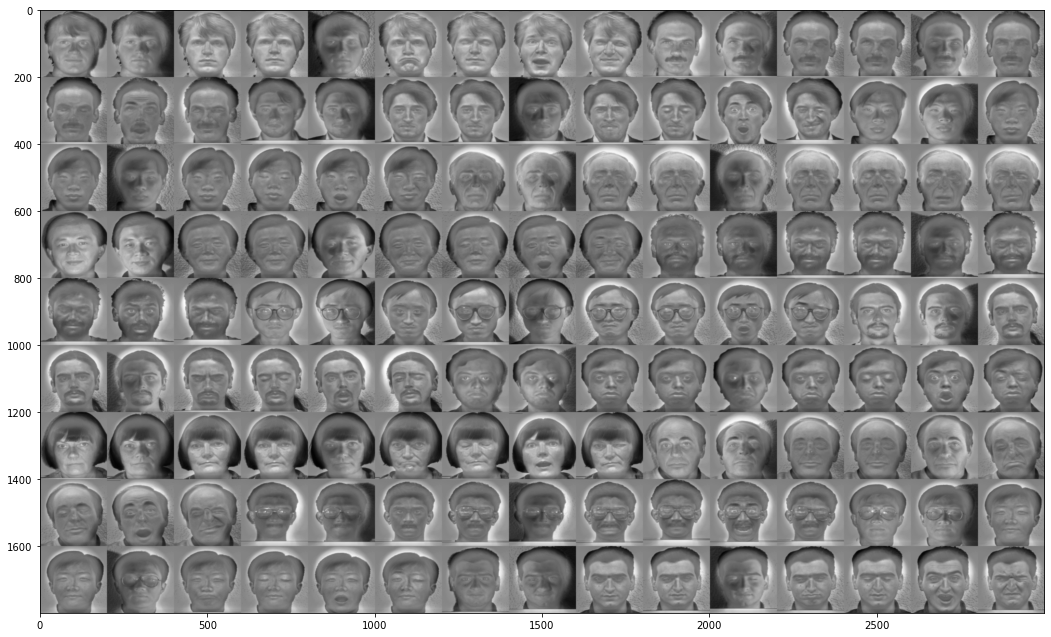

In [140]:
zero_mean =[]
column =0
Zero_mean_matrix= np.ones((40000,135))
# Computing and showing the mean faces
for values in flattened_images:
    #zm = values-mean
    zm= A[:,column] - mean
    #print("z",zm.shape)
    zm = np.squeeze(zm)
    Zero_mean_matrix[:,column] =zm
    zm_images = zm.resize(200,200)
    zero_mean.append(zm)
    column = column +1
print('Mean Face')
result = gallery(np.asarray(zero_mean))
plt.figure(figsize=(18, 18))
plt.imshow(result, interpolation='bilinear',cmap='gray')
plt.show()

In [141]:
d = (np.dot(np.transpose(Zero_mean_matrix),Zero_mean_matrix))/200
u_list =[]
w2, v2 = la.eigh(d)

In [142]:
# Traversing to compute the eigen faces
for ev in v2:
    ev_transpose = np.transpose(np.matrix(ev))
    u = np.dot(Zero_mean_matrix,ev_transpose)                       
    u = u / np.linalg.norm(u)
    u_i= u.reshape(200,200)
    u_list.append(u_i)

Eigen Face


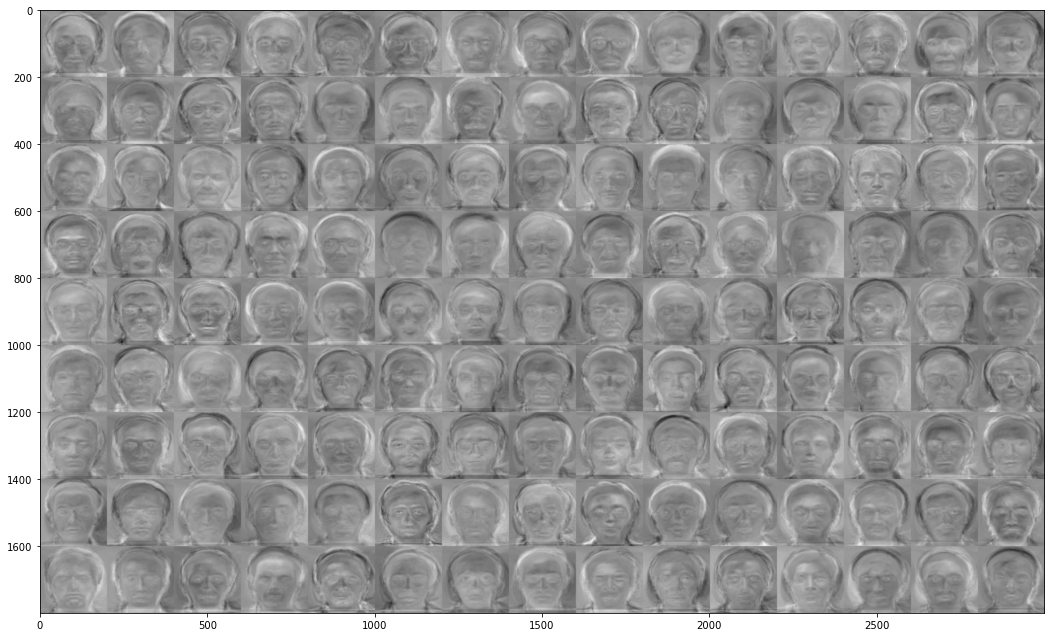

In [144]:
print('Eigen Face')
result = gallery(np.asarray(u_list))
plt.figure(figsize=(18, 18))
plt.imshow(result, interpolation='bilinear',cmap='gray')
plt.show()

		k=10


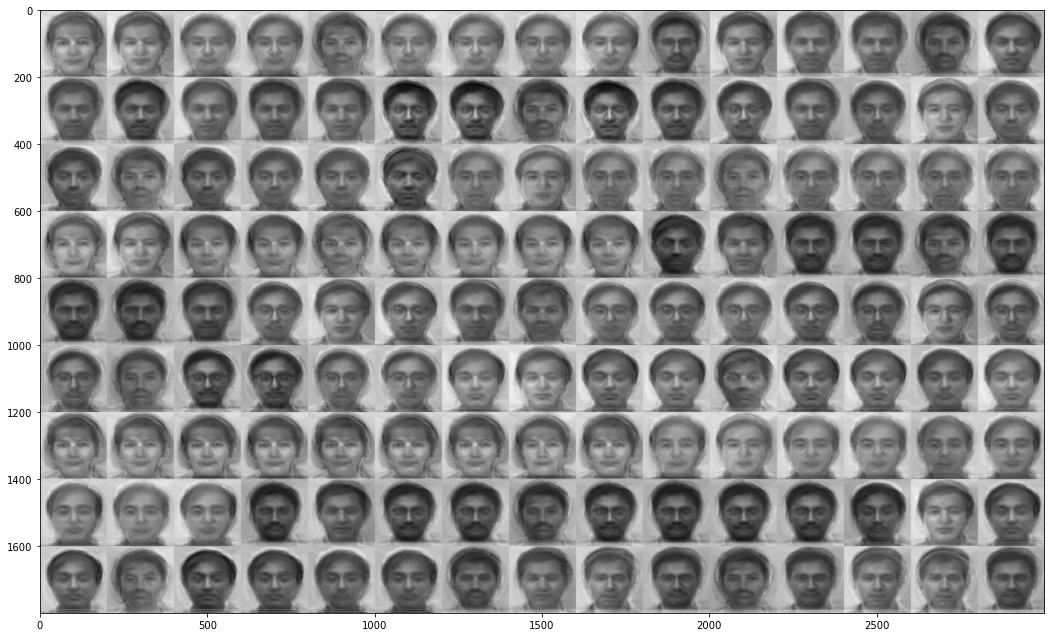

In [145]:
dict ={}
# reconstructing eigen faces using k from 10 to 15
def Reconstruct(k, boolean):
    weights=np.zeros((135,k))
    matrixU = np.zeros((40000,k))
    c =0
    for val in range(k-1,-1,-1):
        matrixU[:,c] = u_list[val].flatten()
        c = c+1
    rec_face=[]
    for face_num in range(0,135):
        w = np.dot(np.transpose(matrixU) ,Zero_mean_matrix[:,face_num])
        weights[face_num,:] =w

        face = np.dot(w, np.transpose(matrixU))
        minf = np.min(face)
        maxf = np.max(face)
        face = face-float(minf)
        face = face/float((maxf-minf))
        face = face+np.transpose(mean)
        reshape_face = face.reshape(200,200)
        rec_face.append( reshape_face)
    if boolean is True:
        result = gallery(np.asarray(rec_face))
        plt.figure(figsize=(18, 18))
        plt.imshow(result, interpolation='bilinear',cmap='gray')
        plt.show()
    dict[k] = weights
    
print('\t\tk=10')
Reconstruct(10,True)

		k=13


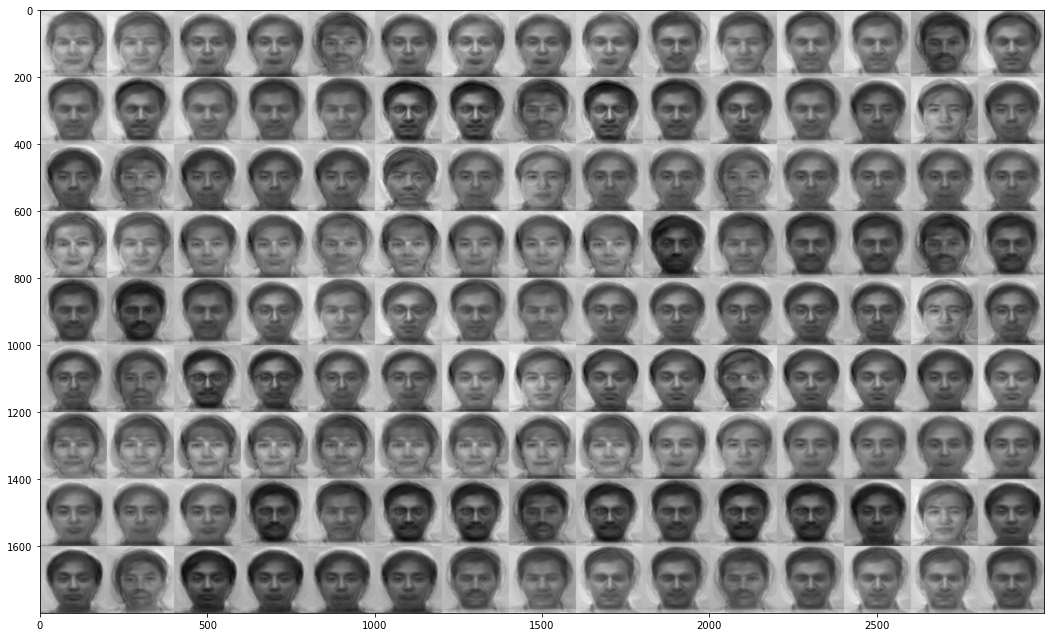

In [146]:
print('\t\tk=13')
Reconstruct(13,True)

Eigen Faces for k=15(Top)


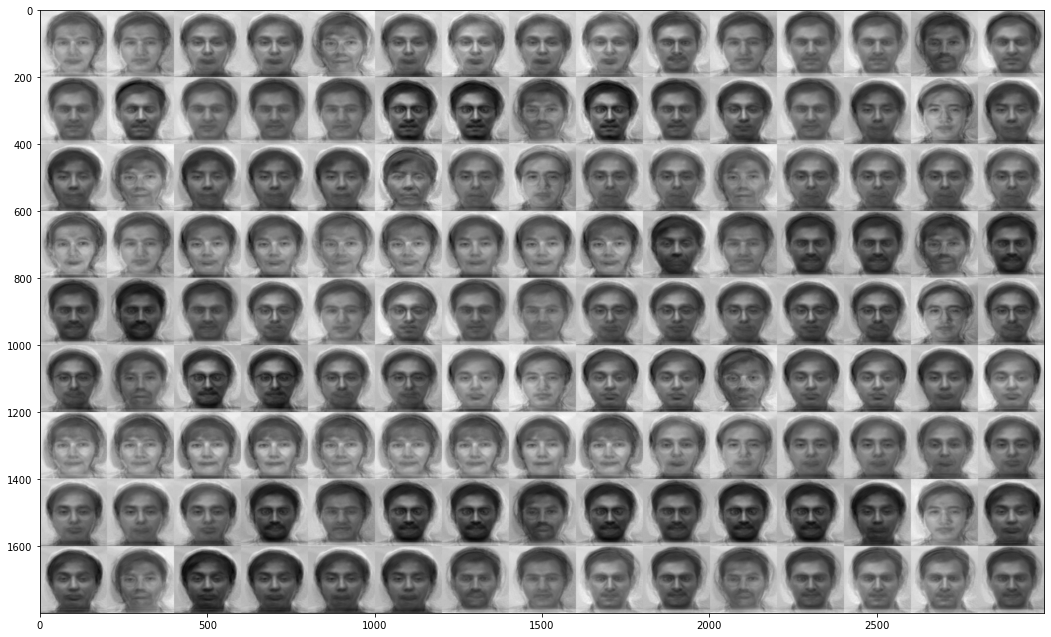

In [147]:
print('Eigen Faces for k=15(Top)')
Reconstruct(15,True)

Projected faces by top k=15


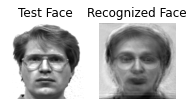

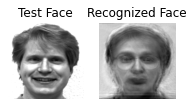

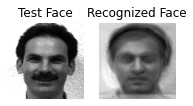

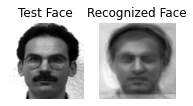

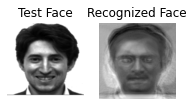

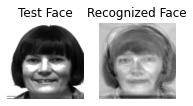

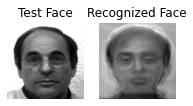

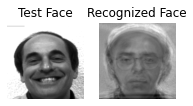

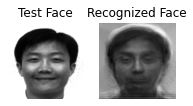

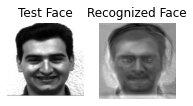

In [155]:
test_images=[]
for filename in glob.glob('Task3/Yale-FaceA/testset/*.png'):
    im=Image.open(filename)
    im= np.asarray(im,dtype=float)
    im = cv2.resize(im,(200,200),interpolation = cv2.INTER_LINEAR)
    im = im/255.0 
    test_images.append(im)
#     projection onto the basis spanned by the top 15 eigenfaces.
def Project(k,zero_mean_test,threshold):
    matrixU = np.zeros((40000,k))
    c =0
    for val in range(k-1,-1,-1):
        matrixU[:,c] = u_list[val].flatten()
        c = c+1
    w = np.dot(np.transpose(matrixU) ,np.transpose(zero_mean_test))
    original_w_k =dict[k]
    dist =[]
    for wt_vectors in original_w_k:
        dist.append(np.linalg.norm(wt_vectors-w.T))

    #using nearest neighbour algorithm
    nearest_face = np.argmin(dist)
    nearest_face_weights = original_w_k[nearest_face]
    fig1, axes_array = plt.subplots(1, 2)
    fig1.set_size_inches(3,3)
    zero_mean_test =zero_mean_test + np.transpose(mean)
    zero_mean_test = zero_mean_test.reshape(200,200)
    image_plot = axes_array[0].imshow(zero_mean_test,cmap=plt.cm.gray)
    axes_array[0].axis('off')
    axes_array[0].set(title='Test Face')

    face = np.dot(nearest_face_weights, np.transpose(matrixU))
    face = face+np.transpose(mean)
    reshape_face = face.reshape(200,200)
    if np.min(dist)<threshold:  #Nonface
        image_plot = axes_array[1].imshow(reshape_face,cmap='gray')
    axes_array[1].axis('off')
    axes_array[1].set(title='Recognized Face')
    plt.show()
    
def runs(k):
    for num in range(0,len(test_images)):#t in test_images:
        t = test_images[num]
        test = t.flatten()
        zero_mean_test = test-np.transpose(mean)
        Project(k,zero_mean_test,80)  #threshold =80

print('Projected faces by top k=15')
runs(15)

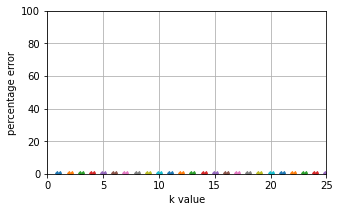

In [154]:
def Error(k,threshold):
    total_images =10
    nf_detected =0
    matrixU = np.zeros((40000,k))
    c =0
    for val in range(k-1,-1,-1):
        matrixU[:,c] = u_list[val].flatten()
        c = c+1
    for t in test_images:
        test = t.flatten()
        zero_mean_test = test-np.transpose(mean)
        w = np.dot(np.transpose(matrixU) ,np.transpose(zero_mean_test))
        original_w_k =dict[k]
        dist =[]
        for wt_vectors in original_w_k:
            dist.append(np.linalg.norm(wt_vectors-w.T))
        if np.min(dist) >threshold:
            nf_detected = nf_detected+1
    error_percentage = ((nf_detected)/total_images)*100
    return error_percentage

xt =[]
for x in range(1,26):
    Reconstruct(x,False)
    xt.append(x)
#print(x)
#xt=[2,5,15]


fig, axes1 = plt.subplots(1, 1)
fig.set_size_inches(5,3)
for x_pts in xt:
    y= Error(x_pts,80)
    axes1.plot(x_pts, y,marker="X")
axes1.set(xlabel="k value",ylabel="percentage error",ylim=(0,100),xlim=(0,25))
plt.grid(True)
plt.show()

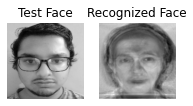

In [158]:
im=Image.open('Task3/Train data/subject16.11.png')
im= np.asarray(im,dtype=float)
im = cv2.resize(im,(200,200),interpolation = cv2.INTER_LINEAR)
im = im/255.0 
test = im.flatten()
zero_mean_test = test-np.transpose(mean)
Project(15,zero_mean_test,80)  #threshold =80

In [159]:
image = []
# Loading all the train images
for filename in glob.glob('Task3/Yale-FaceA/trainingset/*.png'):
    im=Image.open(filename)   
    im= np.asarray(im,dtype=float)
    im = cv2.resize(im,(200,200),interpolation = cv2.INTER_LINEAR)
    im = im/255.0
    image.append(im)
print(len(image))

144


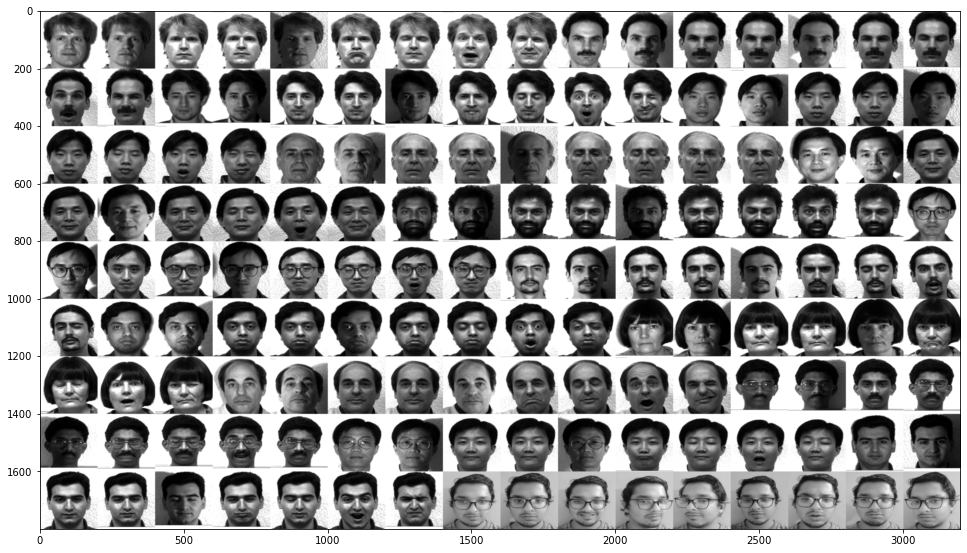

In [165]:
# The function tasks is to view multiple images using single imshow
def gallery(array, ncols=16):
    nindex, height, width = array.shape
    nrows = nindex//ncols
    assert nindex == nrows*ncols
    result = (array.reshape(nrows, ncols, height, width)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols))
    return result
result = gallery(np.asarray(image))
plt.figure(figsize=(16.5, 16.5))
plt.imshow(result, interpolation='bilinear',cmap='gray')
plt.show()

In [166]:
flattened_images = []
for i in range(len(image)):
    p=image[i].flatten()
    flattened_images.append(p)
A_transpose = np.matrix(flattened_images)
A = np.transpose(A_transpose)

mean= np.mean(A,1)
b= mean.reshape(200,200)
resized_mean = cv2.resize(b,(100,100),interpolation = cv2.INTER_LINEAR)

Mean Face


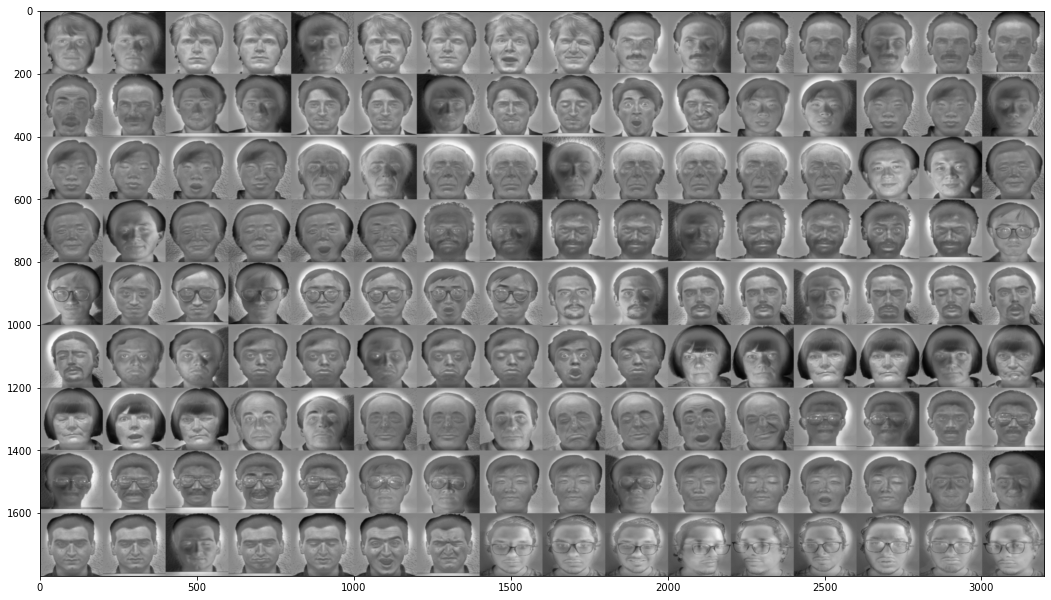

In [167]:
zero_mean =[]
column =0
# Calculating the mean images
Zero_mean_matrix= np.ones((40000,144))
for values in flattened_images:
    zm= A[:,column] - mean
    zm = np.squeeze(zm)
    Zero_mean_matrix[:,column] =zm
    zm_images = zm.resize(200,200)
    zero_mean.append(zm)
    column = column +1
print('Mean Face')
result = gallery(np.asarray(zero_mean))
plt.figure(figsize=(18, 18))
plt.imshow(result, interpolation='bilinear',cmap='gray')
plt.show()

In [168]:
d = (np.dot(np.transpose(Zero_mean_matrix),Zero_mean_matrix))/200
u_list =[]
w2, v2 = la.eigh(d)

In [169]:
for ev in v2:
    ev_transpose = np.transpose(np.matrix(ev))
    u = np.dot(Zero_mean_matrix,ev_transpose)                         
    u = u / np.linalg.norm(u)
    u_i= u.reshape(200,200)
    u_list.append(u_i)

Eigen Face


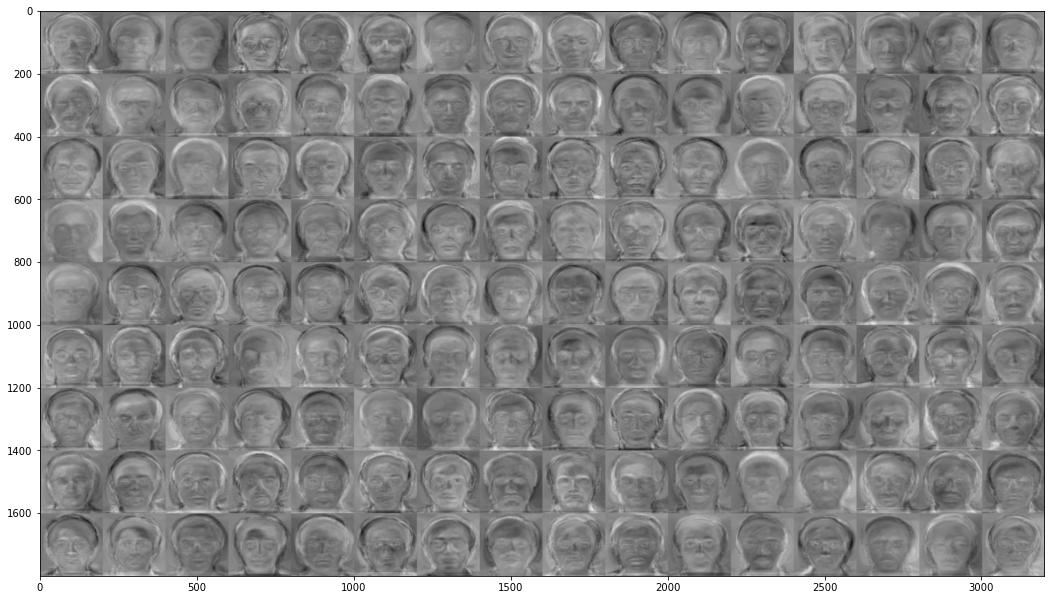

In [170]:
print('Eigen Face')
result = gallery(np.asarray(u_list))
plt.figure(figsize=(18, 18))
plt.imshow(result, interpolation='bilinear',cmap='gray')
plt.show()

Eigen Faces for k=15(Top)


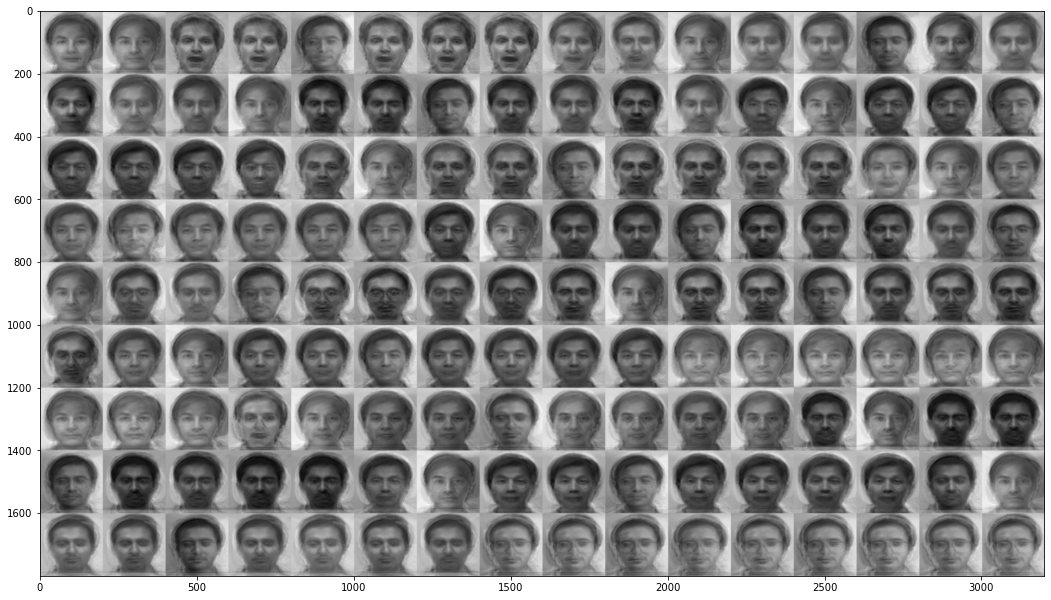

In [172]:
dict ={}
def Reconstruct(k, boolean):
    weights=np.zeros((144,k))
    matrixU = np.zeros((40000,k))
    c =0
    for val in range(k-1,-1,-1):
        matrixU[:,c] = u_list[val].flatten()
        c = c+1
    rec_face=[]
    for face_num in range(0,144):
        w = np.dot(np.transpose(matrixU) ,Zero_mean_matrix[:,face_num]) 
        weights[face_num,:] =w

        face = np.dot(w, np.transpose(matrixU))
        minf = np.min(face)
        maxf = np.max(face)
        face = face-float(minf)
        face = face/float((maxf-minf))
        face = face+np.transpose(mean)
        reshape_face = face.reshape(200,200)
        rec_face.append( reshape_face)
    if boolean is True:
        result = gallery(np.asarray(rec_face))
        plt.figure(figsize=(18, 18))
        plt.imshow(result, interpolation='bilinear',cmap='gray')
        plt.show()
    dict[k] = weights
    
print('Eigen Faces for k=15(Top)')
Reconstruct(15,True)

In [173]:
test_images=[]
for filename in glob.glob('Task3/Yale-FaceA/testset/*.png'):
    im=Image.open(filename)
    im= np.asarray(im,dtype=float)
    im = cv2.resize(im,(200,200),interpolation = cv2.INTER_LINEAR)
    im = im/255.0 
    test_images.append(im)
#     projection onto the basis spanned by the top 15 eigenfaces.
def Project(k,zero_mean_test,threshold):
    matrixU = np.zeros((40000,k))
    c =0
    for val in range(k-1,-1,-1):
        matrixU[:,c] = u_list[val].flatten()
        c = c+1
    w = np.dot(np.transpose(matrixU) ,np.transpose(zero_mean_test))
    original_w_k =dict[k]
    dist =[]
    for wt_vectors in original_w_k:
        dist.append(np.linalg.norm(wt_vectors-w.T))

    #using nearest neighbour algorithm
    nearest_face = np.argmin(dist)
    nearest_face_weights = original_w_k[nearest_face]
    fig1, axes_array = plt.subplots(1, 2)
    fig1.set_size_inches(3,3)
    zero_mean_test =zero_mean_test + np.transpose(mean)
    zero_mean_test = zero_mean_test.reshape(200,200)
    image_plot = axes_array[0].imshow(zero_mean_test,cmap=plt.cm.gray)
    axes_array[0].axis('off')
    axes_array[0].set(title='Test Face')

    face = np.dot(nearest_face_weights, np.transpose(matrixU))
    face = face+np.transpose(mean)
    reshape_face = face.reshape(200,200)
    if np.min(dist)<threshold:  #Nonface
        image_plot = axes_array[1].imshow(reshape_face,cmap='gray')
    axes_array[1].axis('off')
    axes_array[1].set(title='Recognized Face')
    plt.show()

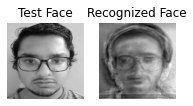

In [174]:
im=Image.open('Task3/Train data/subject16.11.png')
im= np.asarray(im,dtype=float)
im = cv2.resize(im,(200,200),interpolation = cv2.INTER_LINEAR)
im = im/255.0 
test = im.flatten()
zero_mean_test = test-np.transpose(mean)
Project(15,zero_mean_test,80)  #threshold =80

# Thank you